In [1]:
endpoint = 'https://synbiohub.org/sparql?'

query = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX sbh: <http://wiki.synbiohub.org/wiki/Terms/synbiohub#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX sbol: <http://sbols.org/v2#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX purl: <http://purl.obolibrary.org/obo/>

select ?s ?o where {
?s a sbol:ComponentDefinition .
?s sbol:sequence ?seq .
?seq a sbol:Sequence .
?seq sbol:elements ?o .
}
'''

In [2]:
import requests
import urllib.parse

url = endpoint + urllib.parse.urlencode({'query': query})
print(url)
r = requests.get(url)

print(r.status_code)
print(r.encoding)
print(r.headers['content-type'])
print(r.content[0:1000])

f = open('response.xml', 'w')
f.write(r.content.decode('utf8'))

https://synbiohub.org/sparql?query=%0APREFIX+rdf%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F1999%2F02%2F22-rdf-syntax-ns%23%3E%0APREFIX+dcterms%3A+%3Chttp%3A%2F%2Fpurl.org%2Fdc%2Fterms%2F%3E%0APREFIX+dc%3A+%3Chttp%3A%2F%2Fpurl.org%2Fdc%2Felements%2F1.1%2F%3E%0APREFIX+sbh%3A+%3Chttp%3A%2F%2Fwiki.synbiohub.org%2Fwiki%2FTerms%2Fsynbiohub%23%3E%0APREFIX+prov%3A+%3Chttp%3A%2F%2Fwww.w3.org%2Fns%2Fprov%23%3E%0APREFIX+sbol%3A+%3Chttp%3A%2F%2Fsbols.org%2Fv2%23%3E%0APREFIX+xsd%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2001%2FXMLSchema%23%3E%0APREFIX+rdfs%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2000%2F01%2Frdf-schema%23%3E%0APREFIX+purl%3A+%3Chttp%3A%2F%2Fpurl.obolibrary.org%2Fobo%2F%3E%0A%0Aselect+%3Fs+%3Fo+where+%7B%0A%3Fs+a+sbol%3AComponentDefinition+.%0A%3Fs+sbol%3Asequence+%3Fseq+.%0A%3Fseq+a+sbol%3ASequence+.%0A%3Fseq+sbol%3Aelements+%3Fo+.%0A%7D%0A
200
utf-8
application/sparql-results+xml; charset=utf-8
b'<sparql xmlns="http://www.w3.org/2005/sparql-results#" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:s

65385932

In [1]:
f = open('response.xml', 'r')
content = f.read()

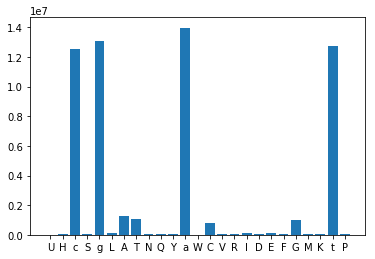

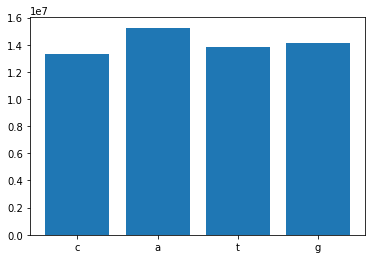

In [16]:
from xml.etree import ElementTree
import matplotlib.pyplot as plt


def create_sequences(xml_content):
    sequences = {}
    
    ns = {'sparql_results': 'http://www.w3.org/2005/sparql-results#'}
    
    root = ElementTree.fromstring(xml_content)
    results = root.find('sparql_results:results', ns)

    for result in results.findall('sparql_results:result', ns):
        bindings = result.findall('sparql_results:binding', ns)

        for binding in bindings:
            if binding.attrib['name'] == 's':
                uri = binding.find('sparql_results:uri', ns).text

        for binding in bindings:
            if binding.attrib['name'] == 'o':
                sequence = binding.find('sparql_results:literal', ns).text

        sequences[uri] = sequence
    
    return sequences


def get_base_frequencies(sequences):
    base_frequencies = {}
    
    for uri, sequence in sequences.items():
        for base in sequence:
            if base not in base_frequencies:
                base_frequencies[base] = 0
            base_frequencies[base] += 1
    
    return base_frequencies


def plot_base_frequencies(base_frequencies):
    plt.bar(range(len(base_frequencies)), list(base_frequencies.values()), align='center')
    plt.xticks(range(len(base_frequencies)), list(base_frequencies.keys()))
    plt.show()

    
def normalize_sequences(sequences, approved_bases):
    for uri in sequences.keys():
        lowered = sequences[uri].lower()
        stripped = ''.join(c for c in lowered if c in approved_bases)
        sequences[uri] = stripped
    

sequences = create_sequences(content)
base_frequencies = get_base_frequencies(sequences)
plot_base_frequencies(base_frequencies)

normalize_sequences(sequences, {'g', 'a', 't', 'c'})
base_frequencies = get_base_frequencies(sequences)
plot_base_frequencies(base_frequencies)

In [10]:
def char_gram(sequence, k):
    grams = set()
    
    for i in range(len(sequence) - k + 1):
        grams.add(sequence[i:i+k])
        
    return grams


def create_grams(sequences, k):
    grams = {}
    
    for uri in sequences.keys():
        gram = char_gram(sequences[uri], k)
        grams[uri] = gram
    
    return grams


def JD(s1, s2):
    '''
    # below was too slow
    intersection = len(s1 & s2)
    union = len(s1 | s2)
    '''
    intersection = 0
    union = len(s1)
    
    for gram in s2:
        if gram in s1:
            intersection += 1
        else:
            union +=1
            
    if union == 0:
        return 1
    
    return 1 - (intersection / union)
            


grams = create_grams(sequences, 3)

In [15]:
def write_grams(grams):
    f = open('grams.txt', 'w')

    for uri in grams:
        f.write(uri + ' ' + ' '.join(grams[uri]) + '\n')

write_grams(grams)

In [6]:
memo = None


def get_JD_memo(key_a, key_b):
    smaller_key = key_a if key_a < key_b else key_b
    larger_key = key_b if key_a < key_b else key_a
    return memo[smaller_key][larger_key]


def create_JD_memo(grams):
    global memo
    
    memo = {}
    
    for key_a in grams:
        for key_b in grams:
            distance = JD(grams[key_a], grams[key_b])
            
            smaller_key = key_a if key_a < key_b else key_b
            larger_key = key_b if key_a < key_b else key_a
                
            if smaller_key not in memo:
                memo[smaller_key] = {larger_key: distance}
            else:
                memo[smaller_key][larger_key] = distance
    

def cluster_indicies(clusters):
    indicies = set()
    
    for key in clusters:
        indicies.add(clusters[key])
        
    return indicies


def cluster_at_index(i, clusters, grams):
    i_grams = {}
    
    for key, value in clusters.items():
        if value == i:
            i_grams[key] = grams[key]
    
    return i_grams
    
    
def closest(grams, clusters, cluster_distance):
    indicies = cluster_indicies(clusters)
    
    clusters_by_index = {}
    for index in indicies:
        clusters_by_index[index] = cluster_at_index(index, clusters, grams)
    
    _min = float('+inf')
    
    for i in indicies:
        for j in indicies:
            if i != j:
                i_cluster = clusters_by_index[i]
                j_cluster = clusters_by_index[j]
                d = cluster_distance(i_cluster, j_cluster)
                
                if d < _min:
                    _min = d
                    most_close = (i, j)
    
    return most_close
    

def hierarchical_cluster(grams, k, cluster_distance):
    print('creating JD memo')
    create_JD_memo(grams)
    
    clusters = {}
    
    for index, key in enumerate(grams.keys()):
        clusters[key] = index
    
    while len(cluster_indicies(clusters)) > k:
        a, b = closest(grams, clusters, cluster_distance)
        
        for key, value in clusters.items():
            if value == a or value == b:
                clusters[key] = min(a, b)
        
        print('merged: ' + str(a) + ' ' + str(b))
        
    return clusters


def shortest_link(cluster_a, cluster_b):
    d = float('+inf')
    
    for key_a in cluster_a:
        for key_b in cluster_b:
            similarity = get_JD_memo(key_a, key_b)
            d = min(d, similarity)
            
    return d

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def show_cdf(results):
    x = sorted(results)
    y = np.arange(1, len(x)+1) / len(x)

    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.title('Jaccard distance cdf with ' + str(len(results)) + ' points')
    _ = plt.xlabel('Jaccard distance')
    _ = plt.ylabel('fraction of experiments that had a lower Jaccard distance')
    plt.margins(0.02) 
    

def flatten(memo):
    results = []
    
    for key_a in memo:
        for key_b in memo[key_a]:
            results.append(memo[key_a][key_b])
            
    return results

('https://synbiohub.org/public/igem/BBa_K1051135/1', {'act', 'tgt', 'acc', 'tag', 'cca', 'gcc', 'tct', 'cgt', 'tgc', 'agt', 'tcg', 'ctt', 'gga', 'aat', 'gct', 'cgc', 'acg', 'gag', 'ata', 'cat', 'ttg', 'taa', 'ctc', 'ccc', 'cct', 'cgg', 'tat', 'atc', 'tac', 'tca', 'ccg', 'aac', 'tgg', 'ttt', 'cag', 'cta', 'ttc', 'gat', 'gca', 'cac', 'tcc', 'tga', 'gtg', 'gtt', 'ggg', 'agc', 'aca', 'aga', 'gcg', 'ggc', 'gaa', 'aag', 'tta', 'cga', 'gta', 'ggt', 'gtc', 'agg', 'caa', 'atg', 'aaa', 'ctg', 'att', 'gac'})
('https://synbiohub.org/public/igem/BBa_Z0146/1', {'gcc', 'acc', 'tgt', 'cca', 'act', 'tag', 'tct', 'cgt', 'tgc', 'ctt', 'agt', 'gga', 'aat', 'gct', 'cgc', 'acg', 'gag', 'ata', 'cat', 'ttg', 'ctc', 'taa', 'ccc', 'cct', 'cgg', 'tat', 'atc', 'tac', 'tca', 'ccg', 'aac', 'tgg', 'cag', 'ttt', 'cta', 'ttc', 'gat', 'cac', 'tcc', 'gca', 'gtg', 'tga', 'ggg', 'gtt', 'agc', 'aca', 'aga', 'gcg', 'ggc', 'gaa', 'aag', 'tta', 'cga', 'gta', 'ggt', 'gtc', 'agg', 'caa', 'ctg', 'atg', 'att', 'gac'})
('https://s

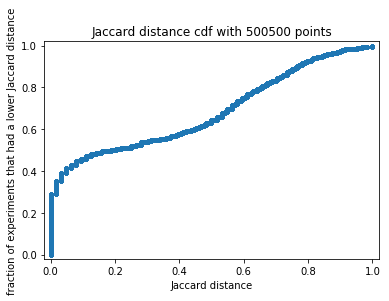

In [8]:
def create_n_grams(grams, n):
    mini_grams = {}
    keys = list(grams.keys())[0:n]
    
    for key in keys:
        mini_grams[key] = grams[key]
    
    return mini_grams


def run_clustering_experiment(n):
    print('total grams: ' + str(len(grams)))
    mini_grams = create_n_grams(grams, n)
    clusters = hierarchical_cluster(mini_grams, 10, shortest_link)
    print(cluster_indicies(clusters))
    
    
mini_grams = create_n_grams(grams, 3)
for gram in mini_grams.items():
    print(gram)
    
create_JD_memo(create_n_grams(grams, 1000))
show_cdf(flatten(memo))

In [9]:
import cProfile
import pstats

cProfile.run('run_clustering_experiment(400)', 'stats')
stats = pstats.Stats('stats')
stats.sort_stats('time').print_stats()


total grams: 48548
creating JD memo
merged: 2 4
merged: 2 9
merged: 2 10
merged: 2 13
merged: 2 14
merged: 2 15
merged: 2 16
merged: 2 17
merged: 2 20
merged: 2 21
merged: 2 22
merged: 2 24
merged: 2 26
merged: 2 27
merged: 2 30
merged: 2 37
merged: 2 38
merged: 2 40
merged: 2 41
merged: 2 42
merged: 2 46
merged: 2 48
merged: 2 49
merged: 2 51
merged: 2 52
merged: 2 53
merged: 2 54
merged: 2 57
merged: 2 58
merged: 2 59
merged: 2 62
merged: 2 63
merged: 2 66
merged: 2 70
merged: 2 72
merged: 2 73
merged: 2 76
merged: 2 78
merged: 2 83
merged: 2 86
merged: 2 87
merged: 2 88
merged: 2 89
merged: 2 90
merged: 2 92
merged: 2 94
merged: 2 95
merged: 2 96
merged: 2 97
merged: 2 98
merged: 2 99
merged: 2 100
merged: 2 101
merged: 2 102
merged: 2 103
merged: 2 104
merged: 2 106
merged: 2 107
merged: 2 108
merged: 2 110
merged: 2 111
merged: 2 113
merged: 2 114
merged: 2 115
merged: 2 117
merged: 2 118
merged: 2 119
merged: 2 120
merged: 2 123
merged: 2 125
merged: 2 126
merged: 2 127
merged: 2

In [1]:
# sort distances, merge in order, union the clusters -> same as single link, but n^2log*n using disjoint set
# incrementally store the distances, ex. go up by .1/some cutoff point
# index grams by short 2^16
# plot JD cdf from just 0 to .1 to determine JD cutoff point
# use role and type to break up dataset
# choose k depending on JD cdf
# times:
# 100 -> 2.422, 200 -> 22.384, 400 -> 188, 800 -> 1367, n^3